# MEDIA FRAMING : THE BIAS IN INTERNATIONAL NEWS COVERAGE #

This notebook presents all of the work we have done to understand the data.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
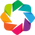

In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import folium
import urllib
import json
import socket
from ipwhois import IPWhois
import pycountry
import io
import requests
import xarray as xr
import numpy as np
import pandas as pd
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import geoviews.tile_sources as gts
import geopandas

from bokeh.palettes import YlOrBr3 as palette

import cartopy
from cartopy import crs as ccrs

from bokeh.tile_providers import STAMEN_TONER
from bokeh.models import WMTSTileSource

hv.notebook_extension('bokeh')

In [10]:
DATA_PATH = "data/"
DATA_PATH = "data/"
MAP_PATH = DATA_PATH + "world.geo.json/countries/"
COUNTRY_CODE_DATA = DATA_PATH + "country-codes/data/country-codes.csv"

# 1. A story of loading and managing the data ##

The first step to start the project is to find a way of handling the data. The GDELT project uses a system of archives where they scrap the whole internet for 15 min to search for news and save their findings in three csv files:
- export: contains information about the events
- mentions: contains information about the articles that mention the events
- gkg: contains analysis of the articles made by gdelt

The main problem here is that we have a tremendous amount of data divided into multiple csv files. Scraping every 15 min means:
- We have 4 csv files per hour for each dataset which represents a total of 4x3 = 12 csv files
- We have 24 hours in a day which means we have 4x24 = 96 csv files per day per dataset which represents a total of 96x3 = 288 csv files per day
- We have a maximum of 31 days in a month which means we have 31x96 = 2 976 csv files per month per dataset which represents a total of 2976x3 = 8 928 csv files per month
- We have 12 months per year which means that we have 12x2976 = 35 712 csv files per month per dataset which represents a total of 3x35 712 = 107 136 csv files per year

In terms of size each dataset represents: 
- Between [300,500] kO <-> [0.3,0.5] MO for the export dataset
  0.5x4 = 2 MO per hour <-> 0.5x96 = 48 MO per day <-> 0.5x2976 = 1 488 MO = 1.5 GO per month <-> 12x1.5 = 18 GO per year 
- Between [600,1500] k0 <-> [0.6,1.5] MO for the mention dataset
  1.5x4 = 6 MO per hour <-> 1.5x96 = 144 MO per day <-> 1.5x2976 = 2 232 MO = 2.25 GO per month <-> 12x2.25 = 27 GO per year
- Between [15,30] MO for the gkg dataset 
  30x4 =  120 MO per hour <-> 30x96 = 2 880 MB = 2.9 GB per day <-> 30x2976 = 89 280 MB = 90 GO per month <-> 12x90 = 1 080 GO = 1 TB per year

Therefore, in a year we have: 18 + 27 + 1 080 = 1 125 GB = 1.13 TB. As we know we have 3 years of data, its total size is 3.3 TB.

This means that the GDELT project database represents terabytes of data which corresponds to the amount of data saved in the cluster.

## 1.1 Get the csv file's URL from the master file list ##

Instead of using the cluster, we decied to start off with using the GDELT website's information. From the url of the masterfilelist.txt we stored the urls of the csv files in a pandas dataframe. Eventually, instead of using the url of the csv files, we will use their pathnames in the cluster.

In [3]:
url='http://data.gdeltproject.org/gdeltv2/masterfilelist.txt'
s=requests.get(url).content

In [6]:
# Loading masterList for scraping the csv files from GDELT database
df_list=pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\s', 
                    header=None, names=['Size', 'Code', 'url'], low_memory=False)

df_list = df_list.dropna(subset=['url'])

df_list['url'].head()

0    http://data.gdeltproject.org/gdeltv2/201502182...
1    http://data.gdeltproject.org/gdeltv2/201502182...
2    http://data.gdeltproject.org/gdeltv2/201502182...
3    http://data.gdeltproject.org/gdeltv2/201502182...
4    http://data.gdeltproject.org/gdeltv2/201502182...
Name: url, dtype: object

In [ ]:
# We get the columns names of the datasets from the text files we've created
col_ex = get_export_names()
col_men = get_mentions_names()

# We define create a list of the column names of the columns we want to keep in the datasets
col_ex_list = ['GlobalEventID', 'Day', 'MounthYear', 'Year', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long', 'GoldsteinScale', 'NumMentions']
col_men_list = ['GlobalEventId', 'MentionSourceName', 'Confidence', 'MentionDocTone']

# We create the empty the aggregated dataframes with the column names we want to keep
export_df = pd.DataFrame(columns=col_ex_list)
mentions_df = pd.DataFrame(columns=col_men_list)

display(export_df.head())
display(mentions_df.head())

print(col_ex)

In [ ]:

def scrape_list(url_ex, url_men, export_df, mentions_df):
    '''
    This function will use the list of export.csv and mentions.csv files to cash their contents and only keep relavant
    columns
    '''
    for i in range(url_ex.shape[0]):
        # Appending is slightly faster than Concat when ignore_index=True, so we used append to add  new scraped dataFrame
        ## But appending gets inefficient for large dataFrame, so instead of appending the new scraped dataframe to a ...
        ## ... large dataFrame, we recursively call our function to use a new empty dataFrame for appending to achieve...
        ## ... much faster speed in scraping large number of dataframes
        if i>= 100:
            level_f += 1
            export_df_2 = pd.DataFrame(columns=col_ex_list)
            mentions_df_2 = pd.DataFrame(columns=col_men_list)
            export_df_2, mentions_df_2 = scrape_list(url_ex.iloc[100:], url_men.loc[100:], export_df_2, mentions_df_2)
            export_df = export_df.append(export_df_2,ignore_index=True)
            mentions_df = mentions_df.append(mentions_df_2,ignore_index=True) 
            break
        else:
            s_ex=requests.get(url_ex.iloc[i])
            s_men = requests.get(url_men.iloc[i])
            if s_ex.status_code==200 and s_men.status_code==200:
                df_i_m=pd.read_csv(io.BytesIO(s_ex.content), sep='\t', compression='zip', names=col_ex)
                df_i_x=pd.read_csv(io.BytesIO(s_men.content), sep='\t',compression='zip', names=col_men)
                export_df = export_df.append(df_i_m[col_ex_list],ignore_index=True)
                mentions_df = mentions_df.append(df_i_x[col_men_list],ignore_index=True)
    return export_df, mentions_df
     

The following codes will go through over 24 months of data set from the beginning of February 2015. This code will scrape the individual `export` and `mentions` data frames and concatenate them and save the result as `export` and `mentions` dataframe for each month.

In [ ]:
# variables to decide
mon_st = 1 # Starting month (February 2015)
mon_en = 24 # Ending Month (February 2017)
month_d = 30 # Number of days within each month (an estimation)

# Going through each month and concatenating the 'export' dataframes together for the whole month and ...
# ... the 'mentions' data frames together for each month
for i in range(mon_st, mon_en):
    # We create the empty the aggregated dataframes with the column names we want to keep
    export_df = pd.DataFrame(columns=col_ex_list)
    mentions_df = pd.DataFrame(columns=col_men_list)

    # Selecting a timeFrame of dataset
    df_ex = df_list[df_list['url'].str.contains('.export.CSV')]
    df_ex = df_ex.iloc[96*month_d*i:96*month_d*(i+1),2:3]
    df_men = df_list[df_list['url'].str.contains('.mentions.CSV')]
    df_men = df_men.iloc[96*month_d*i:96*month_d*(i+1),2:3]

    start_time = time.time()
    # Parsing the data and returning the aggregated dataFrame
    export_df, mentions_df = scrape_listV2(df_ex['url'], df_men['url'], export_df, mentions_df)
    print('Operation time for step {} was equal to: {} seconds'.format(i+1 ,time.time()-start_time))
    export_df.to_csv(data_save+'export_'+str(i+1)+'.csv.gz', compression='gzip')
    mentions_df.to_csv(data_save+'mentions_'+str(i+1)+'.csv.gz', compression='gzip')

# 2. A story of saving the datasets in pandas dataframes ##

Now that we have the urls to the csv files we will need to dowload them to aggregate them into one single dataframe. 
For each dataset (export, mentions and gkg) we create a new pandas dataframe. To name the columns of the datagrame we use the list of column names stored locally in a text file. When aggregating each dataset we try to do it in the least costly way: 
- When we download the csv files we only keep the columns we want to use
- We only download one instance of each type of csv files (export, mentions and gkg), add the csv content to the aggregated dataframe and overwrite the instances for each new url. 

### 2.1 Helpers functions to load the datasets ##

We defined a few functions which help us to easily interact with the data.

```isNaN```: This function detects when a field = float('nan').

```get_export_names```: This function fetches the columns names in the local text file for the *export* dataset.

```get_mentions_name```: This function fetches the columns names in the local text file for the *mentions* dataset.

```get_map_site```: This function return two dictionnaries one that takes a website extension as an input and return the ```ISO3166-1-Alpha-3``` code for said country. The other do the same thing but the other way around. 

In [7]:
def isNaN(num):
    return num != num

def get_export_names():
    file = open(DATA_PATH + "event_table_name", "r")
    names = file.readlines()[0].split(" ")
    return names[:-1]

def get_mentions_names():
    file = open(DATA_PATH + "mentions_table_name", "r")
    names = file.readlines()[0].split(" ")
    return names

def get_map_site():
    file = pd.read_csv(COUNTRY_CODE_DATA)
    return dict(zip(file['TLD'], file['ISO3166-1-Alpha-3'])), dict(zip(file['ISO3166-1-Alpha-3'], file['TLD']))

### 2.2 Columns selection ##

On a side note the reader can find an exhaustive description of each column on the GDELT documentation (available in this repo in the PDF folder)

#### In export ####

- GlobalEventID : This column holds the unique ID for each event displayed in the dataset. It is also the link between the table export and the table mention.

- Actor1Geo_Lat, Actor1Geo_Long : These fields holds the geographical coordinates of the party included in the event. Its content will be display on a map.

- Actor2Geo_Lat, Actor2Geo_Long : Same thing as before. This holds informations about a second actor, if there is one, relative to a specifiv event.

- ActionGeo_Lat, ActionGeo_Long : Same thing as before but this time it holds the geographical coordinates of where the event was. Like the two last paragraph these information will be displayed on a world map.

- GoldsteinScale : This value which calculated how the stability of the country is after an event will be use to compute a homemade index named "Bias".

- SOURCEURL : The URL of the source article, it will be usefull to add this URL to the marker of an event on the map.

#### In mentions ####  

- GlobalEventId : This fields holds the ID of the event from which the article speaks of. On the contrary of the export table an this fileds can be present multiple times through the database (one for each mention).

- MentionSourceName	: This fields holds the short version of the URL of the source. This will be used the geolocalise the soucre of the information since the information is not provided by GDELT

- Confidence : ???

- MentionDocTone : This fields holds a numerical value which quantified the hostility of an article. This feature is very useful in viewing the genral opinion of an article on an event wich will help us highlight biases in informations

In [8]:
# We get the columns names of the datasets from the text files we've created
col_ex = get_export_names()
col_men = get_mentions_names()

# We define create a list of the column names of the columns we want to keep in the datasets
col_ex_list = ['GlobalEventID', 'Day', 'MounthYear', 'Year', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long', 'GoldsteinScale', 'NumMentions']
col_men_list = ['GlobalEventId', 'MentionSourceName', 'Confidence', 'MentionDocTone']

# We create the empty the aggregated dataframes with the column names we want to keep
export_df = pd.DataFrame(columns=col_ex_list)
mentions_df = pd.DataFrame(columns=col_men_list)

display(export_df.head())
display(mentions_df.head())

print(col_ex)

,GlobalEventID,Day,MounthYear,Year,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,GoldsteinScale,NumMentions


,GlobalEventId,MentionSourceName,Confidence,MentionDocTone


['GlobalEventID', 'Day', 'MounthYear', 'Year', 'FractionDate', 'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode', 'Actor1EthnicCode', 'Actor1Religioni1Code', 'Actor1Religion2Code', 'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code', 'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode', 'Actor2EthnicCode', 'Actor2Religioni1Code', 'Actor2Religion2Code', 'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent', 'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_Fullname', 'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type', 'Actor2Geo_Fullname', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code', 'Actor2Geo_ADM2Code', 'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor2Geo_FeatureID', 'ActionGeo_Type', 'ActionGeo_Fullname', 'ActionGeo_CountryCod

# 3. Starting of the visualisation

Using the export and mentions dataframes we came up with three different visualizations to help us answer some of the key questions we would like to answer in this project.

## 3.1. General helper functions to visualize the data ###

In order to visualize different information, we've defined a few functions which help us to extract and interact with the data.

#### 3.1.1 Function 1: treat_event ####
```treat_event```: This function displays the location of an event on a map for one or two actors.

There are two steps in this function: 
- First step: we extract the information of a specific event from the export dataframe given a specfic given ID. Then we further filter all the geographical informations for the the Event, the Actor1 and the Actor2.
- Second step: if present the dataset, for each actor and action a marker for their location is added to the map. We use different colors for each marker: blue for the location of the event, green for the location of Actor 1 and red for the location of Actor 2.

In [11]:
def treat_event(export, mention, id_event, f_map):
    """
        Displays the location of an event on a map and the location of the 
        actors of this event if the information is provided.
    
    Inputs:
    
        export [Pandas dataframe]: 
                    The GDELT export dataset stored in a pandas dataframe
                    
        mentions [Pandas dataframe]:
                    The GDELT mentions dataset stored in a pandas dataframe
                    
        id_event [string]:
                    The ID of the event we are interested in visualizing 
                    
        f_map [folium map]:
                    The map on which the event should be display
    """
    
    # We extract the row corresponding to the event ID in the export dataframe
    data = export.loc[export['GlobalEventID'] == id_event]
    
    # We extract the longitude and the latitude of the Actor 1 from the data
    act_one_lat = data['Actor1Geo_Lat'].values[0]
    act_one_long = data['Actor1Geo_Long'].values[0]

    # We extract the longitude and the latitude of the Actor 1 from the data
    act_two_lat = data['Actor2Geo_Lat'].values[0]
    act_two_long = data['Actor2Geo_Long'].values[0]

    # We extract the longitude and the latitude of the event 
    a_lat = data['ActionGeo_Lat'].values[0]
    a_long = data['ActionGeo_Long'].values[0]
    
    # We extract the URL of one source so that it can be displayed on the map
    src = data['SOURCEURL\n'].values[0]
    
    # We check if the variables aren't empty and we add a marker in different colors
    if not isNaN(a_lat) and not isNaN(a_long):
        folium.Marker(location=[a_lat, a_long], popup=src, icon=folium.Icon(color="blue")) \
              .add_to(f_map)
        
    if not isNaN(act_one_lat) and not isNaN(act_one_long):
        folium.Marker(location=[act_one_lat, act_one_long], popup=src, icon=folium.Icon(color="green")) \
              .add_to(f_map)
        
    if not isNaN(act_two_lat) and not isNaN(act_two_long):
        folium.Marker(location=[act_two_lat, act_two_long], popup=src, icon=folium.Icon(color="red")) \
              .add_to(f_map)

#### 3.1.2 Function 2: src_to_country ####

```src_to_country```: This function displays a color map layer for each country depending on the average tone of the articles from websites based in the country.

If ip = True : we locate the news outlet via its ip. First we do a DNS lookup to optain the IP of the website. From that we run a linux command ```whois``` which allows us to see where the website is based via a ```country``` field. From that we transform the alpha-2 country code into alpha-3 to fetch the json file containing the drawing information for said country.

If ip = False : we geolocalise the website using its extension. Earlier in the notebook we showcased in the helper function the creation of dictionnaries that offers a one to one mapping from website extensions to alpha-3 country code. Once the country code has been retrieved we use the same process as before to draw the country.

Note: It is useful to highlight that the geolocalisation through DNS lookup and whois command needs an active internet connection.

In [12]:
def src_to_country(web, f_map, color, ip = True):
    """
    Displays a color map layer for each country depending on the average 
    tone of the articles from websites based in the country.

    Inputs:

    web [string]: 
                The URL of a website
    f_map [folium map]:
                The map on which we will add the colormap layer
    color [string]:
                The desired color layer for the country  
    ip [boolean]:
                The way we want to localise the article source website
                True: we find the country by IP addresses
                False: we find the country by URL
    """ 
    if ip:
        try:
            obj = IPWhois(socket.gethostbyname(web))
            results = obj.lookup_rdap(obj)
            country = pycountry.countries.get(alpha_2=results['asn_country_code'])
            layout = MAP_PATH + country.alpha_3 + ".geo.json"

            style_function = lambda x: {'fillColor': color}

            folium.GeoJson(layout, style_function).add_to(f_map)
        except:
            pass

    else:
        try:
            site, _ = get_map_site() # get dictionnary
            country = site[str(".") + web.split('.')[-1]] # get web extension
            layout = MAP_PATH + country + ".geo.json"

            style_function = lambda x: {'fillColor': color}

            folium.GeoJson(layout, style_function).add_to(f_map)
        except:
            pass

def src_to_country_v2(web_data): # Look at extension if fail go for ip alpha 3 
    def extension_lookup(website):
        site, _ = get_map_site() # Get dictionary Extensions to County code
        try:
            return site[str('.') + website.split('.')[-1]]
        except:
            return None
        
    def ip_lookup(website):
        try:
            obj = IPWhois(socket.gethostbyname(website))
            results = obj.lookup_rdap(obj)
            country = pycountry.countries.get(alpha_2=results['asn_country_code'])
            return country.alpha_3
        except:
            return None
        
    def two_way_lookup(website):
        ret = extension_lookup(website)
        if ret == None:
            ret = ip_lookup(website)
            return ret
        return ret
        
    return web_data.map(lambda x: two_way_lookup(x))

#### 3.1.3 Function 3: tone_to_color ####

```tone_to_color```: This function provides a mapping from a tone value to a color.

The tone of an article is a score delivered between -100 (negative) and 100 (positive). Most of the time the tone is between -10 and 10, therefore we defined a very simple function to easily get some basic insights. This function will be re-designed in the future.

In [13]:
def tone_to_color(tone): 
    """
    Provides a mapping from a tone value to a color

    Inputs:

    tone [float]: 
                The tone of an article, value in -100, 100[
    """ 
    if tone < 0:
        if tone < -5:
            return "red"
        else:
            return "pink"
    else:
        if tone > 5 :
            return "green"
        else:
            return "lightgreen"

# 4. Visualizations

Now that we have functions to extract information from the data, we can use them to make visualizations.

Note: There are better ways to do the visualization, the idea here was to try the functions and see what we can do. There will be a lot of improvements to be made, we will select a better map, better colors, display legends and color scales etc..

#### 3.2.1 Example 1: Tone of an article for a specific event ####

This is a very simple visualization to test our functions. Here [Example 1](http://localhost:8888/maps/Example1.html) we can see a special case where an event happened in Turkey and the Actor1 and Actor2 are both located in Turkey (the 3 marker are supperposed and we only see the last one corresponding to the location of the event in red). If we click on the marker, we get the URL of the source article. The tone of the article written about the event is very negative as the country is colored in red. 

In [14]:
# Here we try our functions on a small subset of all the data (only one csv for export and mention)
export_d = pd.read_csv(DATA_PATH + "20150218230000.export.CSV",sep='\t', names=get_export_names())
mention_d = pd.read_csv(DATA_PATH + "20150218230000.mentions.CSV", sep="\t", names=get_mentions_names())
#gkg = pd.read_csv(DATA_PATH + "20150218230000.gkg.csv",sep='\t', header=None)

#### 3.2.3 Example 3: Distribution of events being covered by various news sources ####

This visualization we will try to look at how different news sources being covered 

In [8]:
# Preparing the dataframe for plotting
df_plot = df_data.iloc[:,:5].copy()
df_plot = df_plot.groupby(by=['ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long'])\
                 .agg({'GlobalEventID': ['count']}).reset_index()
df_plot.columns = [col[0] for col in df_plot.columns]
df_plot = df_plot.rename(columns={'GlobalEventID':'Mentions'})
df_plot.head()

,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,Mentions
0,AA,12.5000,-69.9667,54
1,AA,12.5167,-70.0333,1
2,AC,16.9167,-62.3167,1
3,AC,17.0000,-61.7667,1
4,AC,17.0167,-61.7667,2


In [11]:
# Changing the two-alphas country code to 3-alphas country code
country_code_df = pd.read_csv(COUNTRY_CODE_DATA)
s = country_code_df.set_index('FIPS')['ISO3166-1-Alpha-3']
df_plot['ActionGeo_CountryCode'] = df_plot['ActionGeo_CountryCode'].replace(s)
df_plot.head()

,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,Mentions
0,ABW,12.5000,-69.9667,54
1,ABW,12.5167,-70.0333,1
2,ATG,16.9167,-62.3167,1
3,ATG,17.0000,-61.7667,1
4,ATG,17.0167,-61.7667,2


In [14]:
# PReparing dataframe for plotting
mentions_ds = gv.Dataset(df_plot[['ActionGeo_Long', 'ActionGeo_Lat','Mentions']])
points = mentions_ds.to(gv.Points, ['ActionGeo_Long', 'ActionGeo_Lat'], ['Mentions'])

In [17]:
# Plotting
(gts.CartoMidnight * points.options(width=900, height=500, tools=['hover'], size_index=2, size=0.1, alpha=0.6, color=palette[2],cmap='YlOrBr'))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [ActionGeo_Long,ActionGeo_Lat]   (Mentions)

<img src="images/plot_03.png">

We can clearly see from this visualization that countries like U.S are mentioning much more than others like countries in South America or latins.

#### 3.2.3 Example 4: Amount of mentions around the world ####

This visualization we will try to show the amount of mentions in different news sources for each countries. We will use this kind of plot for next milestone to show the bias of the news media.

In [20]:
# Defining the geolocations of different countries
path = geopandas.datasets.get_path('naturalearth_lowres')
df = geopandas.read_file(path)
df = df.rename(columns={'gdp_md_est': 'Mentions'})

In [21]:
# Adding the number of mentions to the dataframe
s = df_plot.set_index('ActionGeo_CountryCode')['Mentions']
df['Mentions']=df['iso_a3']
df['Mentions'] = df['Mentions'].replace(s)
df.Mentions = df.Mentions.apply(pd.to_numeric, downcast='integer', errors='coerce')
df = df.dropna()
df = df.drop(columns=['pop_est'])
df.head()

,continent,name,iso_a3,Mentions,geometry
0,Asia,Afghanistan,AFG,1.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,Africa,Angola,AGO,1.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,Europe,Albania,ALB,4.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,Asia,United Arab Emirates,ARE,1.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,South America,Argentina,ARG,9.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [23]:
#plotting
#%%opts Polygons (cmap='Spectral')
plot_opts = dict(tools=['hover'], width=900, height=600, color_index='Mentions',
                 colorbar=True, toolbar='above', xaxis=None, yaxis=None)
gv.Polygons(df, vdims=['name', 'Mentions'], label='Number of mentions around the world for different countries').opts(plot=plot_opts).redim.range(Latitude=(-60, 90))

:Polygons   [Longitude,Latitude]   (name,Mentions)

<img src="images/plot_04.png">
Again we can see that the number of mentions for U.S. is much more higher that other countries


#### Plan for next milestone: ####

1. Further study of the features:

This notebook helped us understand how to aggregate the data and its potential by making simple visualizations using a subset of the features. The next step is to make an exhaustive description and a statistical analysis of all of the features contained in the datasets, including the gkg dataset.

2. Bias measurement:

One issue with our project is to have a way to mesure bias which can be done by using the "Average Tone" or "Goldstein Scale" however this isn't enough. It will be necessary to find a better measurement for bias. For instance we could think of ways to use either supervised or unsupervised machine learning algorithms to group news sources into clusters. This type of study will help us answer some of the questions we couldn't answer yet.

3. Visualizations:

We will have to come up with news visualizations and choose the best ones to answer our different key questions. Instead of maps, we will also need to have more diversified visualizations such as bar charts and graphs.

4. Answer to the key questions

Using the the results of the previous step, we will ned to analyse the results and explain how we can notice biais in internation media coverage.

5. Create a website containing the data story

The idea is to aggreagate everyhting that we did in this project in the form a data story. We will create a website to showcase our visualizations and analysis with each key question getting us closer to answering the main reseach question.

6. Create a poster for the presentation

We will use everything we have done during the project to synthetize the main results in a poster format. 

# 4. On To the Point!

</br> So far, we explained how we planned to handle this big data set (by choosing only a few subset of columns that we will use and by chuncking the data into 24 months). Now, we will move into the main part of the project which is answering our main questions regarding the research question. The main theme of our study will be exploring any sign of discrimination in covering news from countries with different enthinicity, religion, geographic location, or level of prosperity.

## 4.1. A high level view of the news coverage

</br> As a high level study of news coverage we first looked into the different number of news media sources withing different countries and the country of actions in which the event is going to happen.

### 4.1.1. Top countries with the most number of news outlets

### 4.1.2. Top countries with most mentions in the news


## 4.2. Investigating the themes

During the project one we quickly saw a lot of potential in the gkg dataframes. The field that caught our attention was the themes fields. We figured out that in analysing the distribution of themes through would yield out interesting results.

### 4.2.1 Method

By starting from the theme decomposition in homework 3 to the lecture 11 about handling text we figured out that we had all the tools to get this analyse running.

### 4.2.2 Getting the themes:

In the following section we will look how the theme were harvested.

The first transofrmation to the dataframe 

In [ ]:
def aggregate_theme_per_media(gkg_df):
    gkg_df_droped = gkg_df.dropna(subset=['Themes','Locations'])
    gkg_df = gkg_df.astype({'SourceCommonName': str, 'Themes': str})
    
    themes_per_media = pd.DataFrame( {'Source': gkg_df_droped['SourceCommonName'],
                                      'Themes': gkg_df_droped['Themes']})
    
    themes_per_media = themes_per_media.groupby('Source') \
                                   .apply(lambda x: x['Themes'].sum().split(";")) \
                                   .reset_index(name='Themes')
    return themes_per_media

![title](./images/transform_01.png)

### 4.2.3. The bag of themes

From the lecture about handling the text we approach each theme in the same way we would analyse a sentence in a natural language processing application. We wanted to create a matrix which would display for every sources how many time each theme was mentioned.

The following cells display the code used to create this <i>bag of themes</i> that we named <i> occurence matrix </i>

In [ ]:
def check_exists(x, theme_list):
    if(x in theme_list):
        return x
    return np.nan

def theme_distribution(theme, theme_list):
    M = list(map(lambda x: (x,1), theme))
    D = pd.DataFrame(M, columns = ['Themes', 'Count']).groupby('Themes').size() \
                                                      .reset_index(name='Counts') \
                                                      .sort_values(by='Counts', ascending=False)
    D['Themes']=D['Themes'].apply(lambda x: check_exists(x, theme_list))
    D = D.dropna()
    return D['Themes'].values, D['Counts'].values

def distribution_table(themes_per_media, theme_list):
    
    distribution = pd.DataFrame(columns = ['Source', 'Themes', 'Counts'])

    for idx in range(themes_per_media.shape[0]):
        th, ct = theme_distribution(themes_per_media['Themes'][idx].copy(), theme_list)
        distribution = distribution.append(pd.DataFrame({"Source": themes_per_media['Source'][idx],
                                                         "Themes" : [th],
                                                         "Counts":  [ct]}))
    
    distribution = distribution.reset_index()
    distribution = distribution.drop('index', axis=1)
    
    return Distribution

def create_occurence_matrix(distribution, theme_list):

    cols = theme_list
    cols.insert(0,'Source')

    occurence_matrix = pd.DataFrame(columns = cols, index = distribution['Source'])
    occurence_matrix['Source'] = distribution['Source']
    occurence_matrix = occurence_matrix.reindex(distribution['Source'])
    occurence_matrix = occurence_matrix.fillna(0)
    occurence_matrix = occurence_matrix.drop('Source', axis=1)
    occurence_matrix = occurence_matrix.transpose()

    for idx in range(distribution.shape[0]):
        occurence_matrix[distribution['Source'][idx]][distribution['Themes'][idx]] = distribution['Counts'][idx]
    
    return occurence_matrix.transpose()

![title](./images/occurence_matrix.png)

#### 4.2.3.1 Notes about the data

It is important to note that when we started to build this matrix over the GDELT dataset we notified that after a couple of mounth the number of sources was inscreasing very lightly so the final result is the computation over 8 mounth worth of data.

### 4.2.4. PCA vs SVD decomposition

We tried both decomposition to compute a graphical representation.

We struggle to extract any sense from the LA decompostion since only one of the two matrices of the decomposition is available. It is the reson we settled with SVD instead.

SVD provides all the matrices of the decomposition. From that we could highlight what themes are the most important to separates sources from one another.

We also ran a k-means algorithm on the eigenvectors to get a feeling on how close were all the news sources.

In [1]:
def graph_theme_pca(data, components = 32, clusters = 4):
        
    scaler = StandardScaler()
    pca = PCA(n_components = components)
    
    scaler.fit(data)
    pca_mat = pca.fit_transform(scaler.transform(data))
            
    cosine_dst_mat = squareform(pdist(pca_mat, metric='cosine'))
    cosine_mean = np.mean(cosine_dst_mat)
    
    adj_mat = np.vectorize(lambda x: exp(- x**2 / cosine_mean**2))(cosine_dst_mat)
    
    laplacian_mat = laplacian(adj_mat)
    
    eig_val, eig_vect = np.linalg.eig(laplacian_mat)
    
    idx = eig_val.argsort()
    eig_val = eig_val[idx]
    eig_vect = eig_vect[:,idx]
    
    return eig_val, eig_vect, KMeans(n_clusters=clusters).fit(np.real(eig_vect[:,1:7])).labels_

def graph_theme_svd(data, clusters = 4):
    scaler = StandardScaler()
    scaler.fit(data)
    sparse_data = sp.csc_matrix(data.astype('float')) # Use a sparse matrix (as in bag of words)
    
    u,s,vt = sp.linalg.svds(sparse_data)

    latent_themes = np.diag(s)@(vt) # S is an array of value -> need to diagonalize
    
    threshold_for_bug = 0.00000001 # Approximation error led to NaNs
    u[u < threshold_for_bug] = threshold_for_bug
    
    cosine_dst_mat = squareform(pdist(u, metric='cosine'))

    cosine_mean = np.mean(cosine_dst_mat)

    adj_mat = np.vectorize(lambda x: exp(- x**2 / cosine_mean**2))(cosine_dst_mat)
    laplacian_mat = laplacian(adj_mat)
    eig_val, eig_vect = np.linalg.eig(laplacian_mat)
    
    idx = eig_val.argsort()
    eig_val = eig_val[idx]
    eig_vect = eig_vect[:,idx]
    
    return eig_val, eig_vect, KMeans(n_clusters=clusters).fit(np.real(eig_vect[:,1:7])).labels_ , latent_themes

### 4.2.5. Identify and plot underlying features and clusters 

Once we calculated the decompostion it was fairly easy to compute what themes were highlighted by each underlying features.

We also used the result of the k-mean algorithm to see whether there is a real difference in the theme that the media discuss

In [2]:
def get_underlying_main_themes(latent_themes, themes_lst):

    latent_indices = np.argsort(latent_themes, axis=1)[:,-10:]

    return np.vectorize(lambda x: themes_lst[x])(latent_indices)

def plot_underlying(main_themes, latent_themes, latent_indices, num_of_category=4):
    sns.set()

    fig, ax = plt.subplots(num_of_category,1, figsize=(12,24))

    for i in range(num_of_category):
        ax[i].barh(main_themes[i,:], latent_themes[i,latent_indices[i,:]])
    plt.show()
    
def plot_clusters(eig_vect, num_of_category=4):

    x = eig_vect[:,1]
    y = eig_vect[:,2]

    fig, ax = plt.subplots(1, 1, figsize=(12,7))

    #ax.scatter(x, y, c=np.random.rand((eig_val.shape[0])),cmap="viridis", s=65, alpha=0.6)
    for i in range(num_of_category):
        ax.scatter(x, y, c=k_labs,cmap="viridis", s=65, alpha=0.6)

## 4.3. The coverage of the news throughout the world

For this section, we are trying to answer the question: **How differently are international news covered depending on the country or the media?**.

For answering this question, we mainly focused on the United States. We chose United States because of the following resons:
1. It has fairly high number of news media as we will see from the distribution of news sources

2. The political system is fairly transparent

3. It has a multi-national culture which can represent a good segment of world

4. There is always a big debate regarding US subjectivity regarding specific countries like in the middle east.

For achieving this we first had to collection the 'export' and 'mentions' dataframes, merge them together and the process them in order to be able to visualize the desired plots.

### 4.3.1. Cleaning the 'export' and 'mentions' data frame

In [ ]:
DATA_PATH = "data/"
data = 'data/DataFrame/'
COUNTRY_CODE_DATA = DATA_PATH + "country-codes/data/country-codes.csv"
data_read = 'F:/ADA2018/data/'
data_save = 'F:/ADA2018/data/'

In [ ]:
# List of the column names of the columns we want to keep in the datasets
col_ex_list = ['GlobalEventID', 'Day', 'FractionDate', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long', 
               'GoldsteinScale', 'NumMentions', 'IsRootEvent', 'AvgTone', 'SOURCEURL\n']
col_men_list = ['GlobalEventId', 'MentionTimeDate', 'MentionSourceName', 'Confidence', 'MentionDocTone', 
                'MentionDocLen', 'MentionIdentifier']
# Creating lists of columns which should be kept for in the 'export' and 'mentions' dataframe
ex_keep = ['GlobalEventID', 'Day', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 
           'ActionGeo_Long','GoldsteinScale', 'NumMentions', 'AvgTone']
men_keep = ['GlobalEventId', 'MentionSourceName', 'Confidence', 'MentionDocTone']

def make_exlite(month_n):
    '''
    This function gets file's name (month_n: int) as an input, and then only keeps the necessary columns and 
    save it back!
    '''
    # Loading export_df for the month_n
    export_df = pd.read_csv(data_read+'export_'+str(month_n)+'.csv.gz', 
                            compression='gzip', index_col=0, header=0, low_memory=False)
    # Selecting ex_keep columns to keep
    export_df = export_df[ex_keep]
    
    # Creating a list of numerical and categorical columns
    int_list = ['GlobalEventID', 'Day', 
                'NumMentions']
    fl_list = ['ActionGeo_Lat', 'ActionGeo_Long', 'GoldsteinScale', 'AvgTone']
    
    # Downcasting data types to decrease the file size of the dataframe
    export_df.loc[:,int_list] = export_df.loc[:,int_list].apply(pd.to_numeric, 
                                                                downcast='integer', errors='coerce')
    export_df.loc[:,fl_list] = export_df.loc[:,fl_list].apply(pd.to_numeric, 
                                                                downcast='float', errors='coerce')
    # Saving the dataframe
    export_df.to_csv(data_save+'export_'+str(month_n)+'.csv', encoding='utf=8', index=False)
    
    del export_df
    
    return None
       
def make_menlite(month_n):
    '''
    This function gets file's name (month_n: int) as an input, and then only keeps the necessary columns and 
    save it back!
    '''
    # Loading export_df for the month_n
    #mentions_df = pd.read_csv(data_read+str(30*month_n)+'to'+str(30*(month_n+1))+'mentions.csv.gz', compression='gzip', 
    #                          index_col=0, header=0, low_memory=False) data_read+'export_'str(month_n)+'.csv.gz', 
    mentions_df = pd.read_csv(data_read+'mentions_'+str(month_n)+'.csv.gz', compression='gzip', 
                              index_col=0, header=0, low_memory=False)
    # Selecting men_keep columns to keep
    mentions_df = mentions_df[men_keep]
    # Creating a list of numerical and categorical columns
    int_list = ['GlobalEventId']
    fl_list = ['Confidence', 'MentionDocTone']
    
    # Downcasting data types to decrease the file size of the dataframe
    mentions_df.loc[:,int_list] = mentions_df.loc[:,int_list].apply(pd.to_numeric, 
                                                                downcast='integer', errors='coerce')
    mentions_df.loc[:,fl_list] = mentions_df.loc[:,fl_list].apply(pd.to_numeric, 
                                                                downcast='float', errors='coerce')
    # Saving the dataframe
    mentions_df.to_csv(data_save+'mentions_'+str(month_n)+'.csv', encoding='utf=8', index=False)
    
    del mentions_df
    
    return None
    
def load_clean(month_n, usecols_e=None, usecols_m=None):
    '''
    This function gets number of month as an input and load, clean, and merge the associated "export_df" and
    "mentions_df" and return the merged, cleaned dataframe
    '''
    # Loading export_df for the month_n
    export_df = pd.read_csv(data_read+'export_'+str(month_n)+'.csv', usecols=usecols_e, 
                            index_col=None, header=0, low_memory=False)
    # Loading mentions_df for month_n and month_n+1
    mentions_df = pd.DataFrame(columns=men_keep)
    for i in range(month_n, month_n+1):
        mentions_df = pd.concat([mentions_df, 
                                 pd.read_csv(data_read+'mentions_'+str(month_n)+'.csv', usecols=usecols_m,
                                             index_col=None, header=0, low_memory=False)], 
                                join='inner', copy=False, ignore_index=True, sort=False)
    
    #Dropping rows which have NaN in column 'MentionSourceName'
    #mentions_df = mentions_df.dropna(subset=['MentionSourceName'])
    
    # Merging the two dataFrames (export and mentions)
    df_merged = export_df.set_index('GlobalEventID').join(mentions_df.set_index('GlobalEventId'), how='inner')
    
    # Deleting export and mentions dataframes
    del export_df
    del mentions_df
    
    # Reseting index to get back "GlobalEventID" feature
    df_merged = df_merged.dropna(subset=['MentionSourceName']).reset_index()

    # Renaming the first column correctly
    df_merged = df_merged.rename(columns= {df_merged.columns[0]:'GlobalEventID'})

    return df_merged


def add_sourceCountry(df_source, source_name):
    '''
    This function gets df_source (dataframe) and source_name (string) of sourcename. Then it updates the source_df
    to see if there is any new sources to add and then it adds 'SourceCountry' column to df_source and returned
    the updated dataframe
    '''
    def get_map_site():
        file = pd.read_csv(COUNTRY_CODE_DATA)
        return dict(zip(file['TLD'], file['ISO3166-1-Alpha-3'])), dict(zip(file['ISO3166-1-Alpha-3'], file['TLD']))

    def extension_lookup(website):
        try:
            return site[str('.') + website.split('.')[-1]]
        except:
            return None
        
    def ip_lookup(website):
        socket.setdefaulttimeout(1.5)
        
        try:
            ip = socket.gethostbyname(website)
            reader = geolite2.reader()
            output = reader.get(ip)
            results = output['country']['iso_code']
            country = pycountry.countries.get(alpha_2=results)
            return country.alpha_3
        except:
            return np.nan
        
    def two_way_lookup(x):
        ret = extension_lookup(x)
        if ret == None:
            ret = ip_lookup(x)
            return ret
        return ret

    site, _ = get_map_site()
    
    # Creating a copy of df_source
    df_source = df_source.copy()
    # Loading the df_sourceName
    data_source = pd.read_csv(data_read + 'processed/'+source_name +'.csv', index_col=None, header=0, low_memory=False)
    
    # Adding important sources manually
    source_men_list = ['BBC Monitoring','foxnews.com', 'ctpost.com', 'seattlepi.com','beaumontenterprise.com',
                   'lmtonline.com', 'thisdaylive.com','turkishweekly.net','stamfordadvocate.com',
                   'greenwichtime.com']
    source_men_country = ['GBR', 'USA', 'USA', 'USA', 'USA', 'USA', 'NGA', 'TUR', 'USA', 'USA']
    # Concatenating the new info to 'df_sourceName'
    source_df = pd.concat([data_source,pd.DataFrame({'MentionSourceName': source_men_list,
                                           'SourceCountry': source_men_country})], 
                          sort=False, axis=0, ignore_index=True)
    
    # Dropping duplicates to have only the unique source names
    source_df = source_df.drop_duplicates(keep='first').reset_index(drop=True)
    print('**** source_df shape: ', source_df.shape)
    # Getting new list of Source Names
    df_sourceName = df_source.loc[:,'MentionSourceName']
    # Getting unique Source Names by dropping duplicates
    df_sourceName = df_sourceName.drop_duplicates(keep='first').reset_index(drop=True)
    # Merging
    source_df = pd.merge(pd.DataFrame(df_sourceName), 
                         source_df, on=['MentionSourceName'], how='left')
    # Getting Only rows which does not have 'SourceCountry' in the source_df
    df_dict = source_df[~source_df.MentionSourceName.isin(data_source.MentionSourceName)]
    if df_dict.shape[0]!=0:
        # Finding SourceCountries for new newsSources
        df_dict['SourceCountry'] = df_dict.apply(lambda x: two_way_lookup(x.iloc[0]), axis=1)
        # Assigning the newsly scraped SourceCountry back to 
        source_df.loc[~source_df.MentionSourceName.isin(data_source.MentionSourceName)] = df_dict 
        #source_df.apply(lambda x: x.fillna(two_way_lookup(x.iloc[0])), axis=1)
    print('******* End of Apply!')
    # Dropping rows with NAs
    source_df = source_df.dropna(subset=['SourceCountry'])
    
    # Changing Index
    source_df = source_df.set_index('MentionSourceName')['SourceCountry']

    # Adding 'SourceName' column
    df_source['SourceCountry'] = df_source['MentionSourceName'].map(source_df)
    
    return df_source

def mapping_country23(df, column):
    '''
    Mapping 2-digit country codes to 3-digit iso-a3 codes for a selected column: 'column'
    '''
    # Making a copy
    df = df.copy()
    
    # Mapping ActionGeo_CountryCode from 'FIPS' to 'ISO-alpha-3'
    country_code_df = pd.read_csv(COUNTRY_CODE_DATA)
    s = country_code_df.set_index('FIPS')['ISO3166-1-Alpha-3']
    
    # Replacing
    df[column] = df[column].replace(s)
    
    return df


import reverse_geocoder as rg

def ll2cc(df):
    '''
    
    '''
    # creating list of columns
    cc_list = ['City', 'Country']
    ll_list = ['ActionGeo_Lat', 'ActionGeo_Long']
    # Making a copy
    df = df.copy()
    # Dropping rows with NAs in ['ActionGeo_Lat', 'ActionGeo_Long'] columns
    df = df.dropna(subset=ll_list, how='any').reset_index(drop=True)
    # Creating a list of ('Latitude', 'Longitude') tuples
    coordinates = list(df.loc[:,ll_list].astype(float).itertuples(index=False, name=None))
    # Getting 'City' and 'Country' features from 'coordinates'
    df_coord = pd.DataFrame([(x['name'], x['cc']) for x in rg.search(coordinates)], columns=cc_list)
    
    # Concatenating the new ['City', 'Country'] features to 'df_mergedP' 
    df = pd.concat([df, df_coord], axis=1, join='inner')
    return df



def cc2ll(df, df_c2g, resolution='high'):
    '''
    This function gets two columns ['City', 'Country'] for high resolution state or one column ['Country'] for low
    resolution state, and returns their geocode Latitudes and Longitudes. In case of low resolution this function returns
    the latitudes and longitudes of the center of the country
    '''
    if resolution=='high':
        cc_list = ['City', 'Country']
    elif resolution=='low':
        # creating list of columns
        cc_list = ['Country']
    else:
        raise ValueError("Resolution can be set either 'low' or 'high'!")
    
    # List of Lat-Lon column
    ll_list = ['ActionGeo_Lat', 'ActionGeo_Long']
    # Making a copy of dataframe
    df = df.copy()
    # Selecting only cc_list columns
    df_cc = df.loc[:,cc_list]
    # Selecting 'cc_list'+'ll_list' columns from df_c2g
    df_c2g = df_c2g.loc[:,cc_list+ll_list].reset_index(drop=True)
    
    # merging df_cc and df_c2g together to get the 'latitude' and 'Longitude' values
    df_cc = pd.merge(df_cc, df_c2g, how='left', on=cc_list, sort=False)
    # Put the results back to df
    df[['ActionGeo_Lat','ActionGeo_Long']] = df_cc[ll_list]
    # Removing rows with NAs in columns ['ActionGeo_CountryCode','ActionGeo_Lat'] from df_mergedP
    df = df.dropna(subset=['ActionGeo_CountryCode','ActionGeo_Lat'])
        
    return df



In order to be able to handle and process the data frames fast and efficient, we needed to first remove unecessary columns and also downcast the type of columns (whenever it could be downcasted to integer or float). We did that by the help of `make_exlite` and `make_menlite` functions. 

In [ ]:
p_start = 1 # Starting month: February 2015
p_end = 24 # Ending month

# Reading the dataframes from the compressed version, drop unnecessary columns, make them lite , and save them again
for i in range(p_start, p_end):
    make_exlite(i)
    make_menlite(i)

The next step we had to join these two dataframes on `GlobalEventID`, in order to be able to do the necessary statistics.

However, in order to be able to get the desired results, we faced two big challenges:

1. Getting the country of each news media from their URL

2. Removing (or even correct) invalid Latitudes and Longitudes from the datapoints

We will explain in details how we were able to overcome these obstacles.

**1. Getting country of each news media sources:**

</br> For doing this crucial task we used an thre step approaches to both increase the *speed* of finding the source countries and the *accuracy* of finding them. For this reason we wrote the `add_sourceCountry` function. This function first uses a pre-computed dataframe `data_sourceCountry` to map the `MentionSourceName` to their source country. This dataframe is first scraped using the `occuranceSource` function which we will explain later. As a brief descreption, the goal of this function is to go through all of 24 months of data and count the number of mentions from each news media sources. This gives us the ability to know what is the most important news outlets based on their number of occurance.
    </br> Then, the `add_sourceCountry` finds the *MentionSourceNames* that still doesn't have their sources country. In this step, it first look at their URL's extension and try to find their source country if there was any extention. If there is no extention, then it looks uses `IPWhois` method to get the IP of that website and then from IP address it uses `GeoLite` package to get their country. In case that none of those three ways was successful, the function returns `None` as source country for that specific *MentionSourceName*.
    
    
**2. Removing (or correcting) invalid data and noise in Latitudes and Longitudes:**

</br> For this part, we used a creative approach to correct the noise. For handling this, in `ll2cc` function. we first used *reversed geocoding* to get the *City* and *Country* from the latitudes and longitudes. This step is the one that helped us removing the noise. Since the API that we used for this step (`Reverse Geocoder`) returns the nearest City or Country to the specified location on the map. If a latitude-longitude pair is not correct or accurate, then we get the best approximation for that. Then after this step, in function `cc2ll`, we used a database of world's cities from `MaxMind` which contains the world's cities and their correspond latitudes and longitudes.

In [ ]:
def clean_merge(month_n, resolution='high', usecols_e=None, usecols_m=None):
    '''
    This function gets month number as input and do the preprocessing on export or mention dataframe and save the output
    '''
    
    if resolution=='high' or resolution=='low':
        # Loading export dataframe
        df_merged = load_clean(month_n, usecols_e=usecols_e, usecols_m=usecols_m)
        # Adding SourceCountry
        df_merged = add_sourceCountry(df_merged, 'data_SourceCountry')
        # Mapping 2-digit country codes to 3-digit
        df_merged = mapping_country23(df_merged, column='ActionGeo_CountryCode')
        # Cleaning the noise of Lat-Lon values
        df_merged = ll2cc(df_merged)
        df_merged = cc2ll(df_merged, df_c2g, resolution=resolution)
    else:
        raise ValueError('Resolution can only gets "high" or "low" as values!')
    # Keeping only relevant columns
    col_keep = ['GlobalEventID','Day', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long',
                'GoldsteinScale','NumMentions','AvgTone', 'MentionSourceName','Confidence',
                'MentionDocTone','SourceCountry']
    df_merged = df_merged[col_keep]
    
    return df_merged


In [ ]:
##### Loading df_country2geocode for high resolution
# Loading 'data_country2geo'
df_c2g = pd.read_csv(DATA_PATH + 'data_country2geo.csv', index_col=0, header=0)
# Renaming the columns
df_c2g.columns = ['Country','City', 'AccentCity', 'ActionGeo_Lat', 'ActionGeo_Long']
# Dropping duplicates
df_c2g = df_c2g.drop_duplicates(subset=['Country', 'City'], keep='first')
# creating list of columns

##### Loading df_country2geocode for low resolution
'''# Loading 'data_country2geo'
df_c2g = pd.read_csv(DATA_PATH + 'countries_lat-lon.txt', sep='\t',index_col=None, header=0)
df_c2g.columns = ['Country', 'ActionGeo_Lat', 'ActionGeo_Long', 'Name']
# Dropping duplicates
df_c2g = df_c2g.drop_duplicates(subset=['Country'], keep='first')'''

<img src="./images/distS_01.png">

In [ ]:
p_start = 1
p_end = 23
# Columns to read from export_df and mentions_df
ex_keep = ['GlobalEventID', 'Day', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 
           'ActionGeo_Long','GoldsteinScale', 'NumMentions', 'AvgTone']
men_keep = ['GlobalEventId', 'MentionSourceName', 'Confidence', 'MentionDocTone']

# Iterating over months for creating df_merged for each month and then saving the cleaned and lite version
for i in range(p_start, p_end+1):
    print('***** Month {} has started!'.format(i))
    # Loading, dropping the unnecessary columns, adding source country, and cleaning and removing noise from 
    # ... latutudes and longitudes
    df_merged = clean_merge(i, usecols_e=ex_keep, usecols_m=men_keep)
    # Saving the df_merged
    df_merged.to_csv(data_save+'merged_'+str(i)+'.csv', index=False, encoding='utf-8')

### 4.3.2. Creating 'MentionSourceName' Occurance and their 'SourceCountry 

</br> This is the step that we have mentioned in the previous part, in which we scrape all 24 months of data and then store the `MentionSourceName` and their `Occurance` (total number of mentions). For doing that we again used the two optimized function `occuranceSource` and `sourceCount` which can do the task for us. Of course, after scraping the whole 24 months of data, we find the news sources country by using previously explained `add_sourceCountry` function and stoing them for efficient mapping of `MentionSourceName` to `SourceCountry` in the later tasks.

In [ ]:
def sourceCount(df_sources, month_n):
    '''
    This function go through indicated month in mentions dataframe and count the number of their occurance.
    Then, if updates the dataframe 'df_sources' by adding the new number of occurance 
    '''
    # Creating a copy of dataframe
    df_sources = df_sources.copy()
    
    # Loading cleaned dataframe
    mentions_df = pd.read_csv(data_read+'mentions_'+str(month_n)+'.csv.gz', compression='gzip',
                              index_col=0, header=0, usecols= ['MentionSourceName', 'GlobalEventId'],
                              low_memory=False)
    # Counting the occurance
    mentions_df = mentions_df.groupby(by=['MentionSourceName'])['GlobalEventId'].count()\
                             .reset_index(name='Occurance')#.set_index('MentionSourceName')
    # Merging new 'MentionSourceName' to the df_sources
    df_sources = pd.merge(df_sources, mentions_df, how='outer', on=['MentionSourceName'], sort=False)
    # Filling NAs with zero, so that we can sum two columns together
    df_sources = df_sources.fillna(0)
    # Adding two columns together to update the number of occurance
    df_sources['Count'] = df_sources['Count'] + df_sources['Occurance']
    # Removing 'Occurance' column
    df_sources = df_sources[['MentionSourceName', 'Count']]
    
    return df_sources


def occuranceSource(df_sources=None, p_start=1, p_end=1):
    '''
    This function returns the dataframe containing 'MentionSourceName' and their 'Occurance'
    '''
    if df_sources is None:
        df_sources = pd.DataFrame(columns=['MentionSourceName', 'Count'])
    # Iterating over the period to get the number of occurance
    for i in range(p_start, p_end+1):
        df_sources = sourceCount(df_sources, i)
    # Sorting the 'MentionSourceName'
    df_sources = df_sources.sort_values(by=['Count'], ascending=False)
    
    return df_sources

In [ ]:
# Computing MentionSourceName occurance
df_sources = occuranceSource(p_start=1, p_end=3)

df_sources.head()

<img src="./images/distS_02.png">

In [ ]:
# Finding their 'SourceCountry'
df_sources = add_sourceCountry(df_sources, 'data_sourceName')

# Saving the result
df_sources.to_csv(data_save+'data_sourceOccurance.csv', encoding='utf=8', index=False)

df_sources.head()

<img src="./images/distS_03.png">

### 4.3.3. Preparing dataframes for Point plotting to visualize the geolocation and intensity of coverage

</br> In this step, we have the preprocessed dataframes `df_merged` for all 24 months and the only think the we need to do is to process the data to get the total mentions per `ActionGeo_CountryCode` (which is the country in which the action of the event happened) and per `MentionSourceName` and `Month`.

In [ ]:

def df4pointPlot(p_start=1, p_end=1):
    # Columns list needed for plotting
    col_list = ['ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long', 'Month', 'MentionSourceName', 'SourceCountry']
    # Creating empty dataframe for plotting
    df_plot = pd.DataFrame(columns=col_list)
    
    # Columns needed from export_df and mentions_df
    col_e = ['GlobalEventID', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long']
    col_m = ['GlobalEventId', 'MentionSourceName']
    
    # Iterating over months to add number of mentions
    for i in range(p_start, p_end+1):
        # Loading the merged and cleaned dataframe for month i
        df_merged = pd.read_csv(data_read+'merged_'+str(i)+'.csv', index_col=None, low_memory=False)
        # Computing number of mentions by grouping by 'Action_Geo_CountryCode' and 'Lat' and 'Long'
        df_merged = df_merged.groupby(by=['ActionGeo_CountryCode', 'MentionSourceName', 'SourceCountry',
                                          'ActionGeo_Lat', 'ActionGeo_Long'])['GlobalEventID']\
                             .count().reset_index(name='Mentions')
        # Adding month column
        df_merged['Month'] = i
        #Concatenating the result to df_plot
        df_plot = pd.concat([df_plot,df_merged], axis=0, join='outer', copy=False, ignore_index=True, sort=False)

    # Summing up number of mentions per 'Country' and 'City' and 'MentionSourceName'
    df_plot = df_plot.groupby(by=['ActionGeo_CountryCode', 'MentionSourceName', 'Month', 'SourceCountry',
                                  'ActionGeo_Lat', 'ActionGeo_Long'])['Mentions']\
                     .sum().reset_index(name='Mentions').sort_values(by=['Mentions'], ascending=False)
    return df_plot
    

    
def point_plot(df, plot_name='Point_plot', resolution='high'):
    '''
    This function gets a dataframe containing information of 'Action Country', 'Latitude', 'Longitude', and 'Mentions'
    as input and plot the coverage geographic map
    '''
    # Making a copy
    df = df.copy()
    # Columns list needed for plotting
    col_list = ['Mentions', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long']

    
    if resolution=='high':
        # Getting percentage of mentions for each country/city
        df.Mentions = df.Mentions*100.0/df.Mentions.sum()
        
        # Preparing dataframe for plotting
        mentions_ds = gv.Dataset(df[['ActionGeo_Long', 'ActionGeo_Lat','Mentions', 'ActionGeo_CountryCode']])
        points = mentions_ds.to(gv.Points, ['ActionGeo_Long', 'ActionGeo_Lat'], ['Mentions', 'ActionGeo_CountryCode'])
        # Plotting with Hover tool
        hover = HoverTool(tooltips=[("Country", "@ActionGeo_CountryCode"), ('Percentage of Mentions', 
                                                                                 '@Mentions{0.1f} %')])
        p = (gts.CartoMidnight * points.options(width=900, height=500, tools=[hover], size_index=2, size=10, 
                                         alpha=0.7, color=palette[2],cmap='YlOrBr'))
    elif resolution=='low':
        # Getting percentage of mentions for each country/city
        df.Mentions = df.Mentions*100.0/df.Mentions.sum()
        
        # Preparing dataframe for plotting
        mentions_ds = gv.Dataset(df[['ActionGeo_Long', 'ActionGeo_Lat','Mentions', 'ActionGeo_CountryCode']])
        points = mentions_ds.to(gv.Points, ['ActionGeo_Long', 'ActionGeo_Lat'], ['Mentions', 'ActionGeo_CountryCode'])
        # Plotting with Hover tool
        hover = HoverTool(tooltips=[("Country", "@ActionGeo_CountryCode"), ('Percentage of Mentions', '@Mentions{0.1f} %')])
        # Saving the Plot (First option)
        p = (gts.CartoMidnight * points.options(width=900, height=500, tools=[hover], size_index=2, size=10, 
                                         alpha=0.8, color=palette[2],cmap='YlOrBr'))
    else:
        raise ValueError('Resolution can only gets "low" or "high" as values!')
    renderer = hv.renderer('bokeh')
    # Using renderer save
    renderer.save(p, './plots/'+plot_name)
    
    return None



In [ ]:
# Computing 'MentionSourceName' mentions for each 'ActionGeo_CountryCode', 'ActionGeo_Lat', and 'ActionGeo_Long'
df_pplot = df4pointPlot(p_start=1, p_end=19)

# Saving the Result
df_pplot.to_csv(data_save+'data_pointPlot.csv', encoding='utf=8', index=False)

df_pplot.head()

<img src="./images/distS_04.png">

### 4.3.4. Plotting the aggregation of U.S. news media of the world over 19 months of data

In [ ]:
# Loading the 'data_pointPlot'
df_pplot = pd.read_csv(data_save+'data_pointPlot.csv', index_col=None, low_memory=False)

df_pplot.head()

<img src="./images/distS_08.png">

In [ ]:
# Filter Source country to USA
df_pplot = df_pplot[df_pplot.SourceCountry=='USA']

# Aggregating the data frame over 24 months to get the sum of mentions over months
df_pplot = df_pplot.groupby(by=['ActionGeo_CountryCode', 'ActionGeo_Lat','ActionGeo_Long'])\
                   .agg({'Mentions':'sum'}).reset_index().sort_values(by=['Mentions'], ascending=False)
print(df_pplot.shape)
df_pplot.head()

<img src="./images/distS_09.png">

In [ ]:
plot_name = 'coverage_plot_high'
point_plot(df_pplot, plot_name=plot_name, resolution='high')

# Showing the plot
from IPython.display import HTML
HTML(filename='./images/'+plot_name+'.html')

**You can find the interactive version of the plot on the website version of the project**

<img src="./images/distS_10.png">

### 4.3.4. Animation of Coverage plot

</br> For having a good sense of how the coverage of U.S. news sources is changing over time, we created an animation plot, which can easily show the coverage based on their geographic location.

From the results, we can see that most of the news coverage is from U.S. and then the G8 countries, and in the end we can see some big circle appears in the middle east region which suggest there might be a bad news regarding them.

In [ ]:
# Loading the 'data_pointPlot'
df_pplot = pd.read_csv(data_save+'data_pointPlot.csv', index_col=None, low_memory=False)

df_pplot.head()

<img src="./images/distS_08.png">

In [ ]:
# Filter Source country to USA
df_pplot = df_pplot[df_pplot.SourceCountry=='USA']

# Aggregating the data frame to get the sum of mentions over months
df_pplot = df_pplot.groupby(by=['ActionGeo_CountryCode', 'Month', 'ActionGeo_Lat','ActionGeo_Long'])\
                   .agg({'Mentions':'sum'}).reset_index().sort_values(by=['Mentions'], ascending=False)
print(df_pplot.shape)
df_pplot.head()

<img src="./images/distS_07.PNG">

In [ ]:
# Creating a copy of data frame
df_plot = df_pplot.copy()
# Getting percentage of mentions for each country/city
df_plot.Mentions = df_plot.Mentions*100.0/df_plot.Mentions.sum()

In [ ]:
import geoviews.tile_sources as gts
from bokeh.io import show
from bokeh.layouts import layout
from bokeh.models import Slider, Button
from bokeh.palettes import YlOrBr3 as palette
from bokeh.plotting import show, output_notebook, curdoc, output_file

renderer = hv.renderer('bokeh').instance(mode='server')

# Create the holoviews app again
def sine(phase):
    # Plotting with Hover tool
    hover = HoverTool(tooltips=[("Country", "@ActionGeo_CountryCode"), ('Percentage of Mentions', '@Mentions{0.1f} %')])
    # Creating geopandas dataframe
    mentions_ds = gv.Dataset(df_plot[df_plot['Month']==phase]\
                            [['ActionGeo_Long', 'ActionGeo_Lat', 'Mentions', 'ActionGeo_CountryCode']])
    points = mentions_ds.to(gv.Points, ['ActionGeo_Long','ActionGeo_Lat'], ['Mentions', 'ActionGeo_CountryCode'])
    return (gts.CartoMidnight * points.options(width=900, height=500, tools=[hover], size_index=2, size=22, 
                                         alpha=0.8, color=palette[2],cmap='YlOrBr'))

stream = hv.streams.Stream.define('Phase', phase=1.)()
dmap = hv.DynamicMap(sine, streams=[stream]) #Here we call sine to update plot with the stream (defined above)

# Define valid function for FunctionHandler
# when deploying as script, simply attach to curdoc
def modify_doc(doc):
    # Create HoloViews plot and attach the document
    hvplot = renderer.get_plot(dmap, doc)

    # Create a slider and play buttons
    def animate_update():
        year = slider.value + 1.0
        if year > end:
            year = start
        slider.value = year

    def slider_update(attrname, old, new):
        # Notify the HoloViews stream of the slider update 
        stream.event(phase=new)
        
    start, end = 1, 19
    slider = Slider(start=start, end=end, value=start, step=1, title="Months (Base Month: February 2015)")
    slider.on_change('value', slider_update)
    
    callback_id = None

    def animate():
        global callback_id
        if button.label == '► Play':
            button.label = '❚❚ Pause'
            callback_id = doc.add_periodic_callback(animate_update, 500) #This number change the time between each update
        else:
            button.label = '► Play'
            doc.remove_periodic_callback(callback_id)
    button = Button(label='► Play', width=60)
    button.on_click(animate)
    
    # Combine the holoviews plot and widgets in a layout
    plot = layout([
    [hvplot.state],
    [slider, button]], sizing_mode='fixed')
    
    doc.add_root(plot)
    return doc

# To display in the notebook
#output_file("graph.html")
show(modify_doc, notebook_url='localhost:8888')

# To display in a script
#doc = modify_doc(curdoc())

**The animated version of the graph**

<img src="./images/coverage_animation.gif">

## 4.4 The Bias

 The objective here to see whether a country like the United States, how well speaks about other countries. Is there any particular countries that United States tends to speak more positively about them? or in a sense, can we say that there is any bias regarding the coverage of the countries?

 Introducing a good feature for measuring the bias is really hard. There is no ground truth to which we can refer for measuring the degree of dispersion from objectivity and also there is no universal feature to show this degree of dispersion.

 Using machine learning approach to predict this degree of disperion could seem a good choice for this application, but since there is no training set which can tell us e.g. the degree of bias and also any attempt for using machine learning approached requires diving into the NLP pipelines, which require high power of computation to be able to load each document, run the algorithm and extract the result, we tried to use the current features that we had for measuring the bias.

 By exploring the features, we can see that a good candidate for measuring the bias could be the difference between `MentionDocTone` and `AvgTone`.

`AvgTone` shows the mean of tones within several mentions from different news sources. By believing that the democracy of sources can leads to objective opinion about an event, we think that using `AvgTone` as a proxy for measuring the ground truth would the best approximation of ground truth with reasonable effort. This choice can give us the ability to both having a measurement for **ground truth** and also by having `MentionDocTone` feature for each mention, we can calculate the dispersion perfectly for each event. Thus, in order to measure the **bias** we will build a new feature by subtracting `MentionDocTone` from `AvgTone`.


 In order to do that, we starts again from processing the 'export' and 'mentions' dataframe, merging the, cleaning, and analysing for plotting.

### 4.4.1 to 4.4.2.

These Steps would be the same as `3.4.1` and `3.4.2` steps.

### 4.4.3. Preparing dataframes for plotting the bias

</br> In this section, we use the following function to processing the resulted `df_merged` dataframes and plotting the bias map.

In [2]:
def df4biasPlot(p_start=1, p_end=1):
    def get_weightedAvg(x):
        '''
        This function returns the weighted average of dataframe 'x'.
        Dataframe 'x' should contains two columns ['Avg', 'Count']
        '''
        return (x.loc[:,'AvgBias']*x.loc[:,'Count']).sum()/x.loc[:,'Count'].sum()
    
    # Columns list needed for plotting
    col_list = ['AvgBias', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long', 'Month']
    # Create empty dataframe for plotting
    df_plot = pd.DataFrame(columns=col_list)
    # Columns for export_df and mentions_df
    col_e = ['GlobalEventID', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long', 'AvgTone']
    col_m = ['GlobalEventId', 'MentionSourceName', 'MentionDocTone']
    # Iterating over months to add number of mentions
    for i in range(p_start, p_end+1):
        # Loading the merged and cleaned dataframe for month i
        df_merged = pd.read_csv(data_read+'merged_'+str(i)+'.csv', index_col=None, low_memory=False)
        # Making Bias column
        df_merged['Bias'] = df_merged['MentionDocTone']-df_merged['AvgTone']
        # Dropping redundant columns
        df_merged = df_merged.drop(columns=['AvgTone', 'MentionDocTone'])
        # Computing number of mentions by grouping by 'Action_Geo_CountryCode' and 'Lat' and 'Long'
        df_merged = df_merged.groupby(by=['ActionGeo_CountryCode', 'MentionSourceName',
                                          'ActionGeo_Lat', 'ActionGeo_Long'])\
                             .agg({'Bias':'mean', 'MentionSourceName':'count'})

        df_merged = df_merged.rename(columns={'Bias':'AvgBias', 'MentionSourceName':'Count'}).reset_index()
        # Adding new column month
        df_merged['Month'] = i
        #Concatenating the result to df_plot
        df_plot = pd.concat([df_plot,df_merged], axis=0, join='outer', copy=False, ignore_index=True, sort=False)

    # Summing up number of mentions per 'Country' and 'City' and 'MentionSourceName'
    df_grouped = df_plot.groupby(by=['ActionGeo_CountryCode', 'MentionSourceName', 'Month',
                                  'ActionGeo_Lat', 'ActionGeo_Long'])
    
    df_bias= df_grouped.apply(lambda x: get_weightedAvg(x)).reset_index(name='AvgBias')['AvgBias']
    
    df_count = df_grouped.apply(lambda x: x.loc[:,'Count'].sum()).reset_index(name='AvgBias')['AvgBias']
    # Reducing the df_plot
    df_plot = df_grouped.agg({'ActionGeo_CountryCode':'count'}).rename(columns={'ActionGeo_CountryCode':'AvgBias'}).reset_index()
    # Assigning values to associated columns
    df_plot['AvgBias'] = df_bias
    df_plot['Count'] = df_count
    
    return df_plot




from bokeh.models import HoverTool

%%opts Polygons (cmap='Spectral')
from bokeh.models import HoverTool

def bias_plot(df_plot, plot_name='Bias_plot'):
    
    # Making a copy
    df_plot = df_plot.copy()
    # Columns list needed for plotting
    col_list = ['AvgBias', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long']
    
    # Loading the geolocations of different countries
    path = geopandas.datasets.get_path('naturalearth_lowres')
    df = geopandas.read_file(path)
    # Dropping unnecessary columns
    df = df.drop(columns=['pop_est', 'gdp_md_est'])

    # Adding the number of mentions to the dataframe
    s = df_plot.set_index('ActionGeo_CountryCode')['AvgBias']
    df['AvgBias']=df['iso_a3']
    df['AvgBias'] = df['AvgBias'].replace(s)
    df.AvgBias[df.AvgBias.isin(df['iso_a3'])] = 0
    
    df.AvgBias = df.AvgBias.apply(pd.to_numeric, downcast='float', errors='coerce')
    # droping NAs
    df = df.dropna()
    
    # Plotting with Hover tool
    hover = HoverTool(tooltips=[("Country", "@iso_a3"),('Average Bias',
                                                                       '@AvgBias')])

    
    plot_opts = dict(tools=[hover], width=900, height=600, color_index='AvgBias',colorbar=True, toolbar='above', xaxis=None, yaxis=None, cmap='Spectral')
    p = gv.Polygons(df, vdims=['name', 'AvgBias'], label='Average Bias for U.S. news media around the world').opts(plot=plot_opts).redim.range(Latitude=(-60, 90))
    renderer = hv.renderer('bokeh')
    # Using renderer save
    renderer.save(p, './plots/'+plot_name)
    
    return None


### 4.4. Plotting the Bias 

In [ ]:
df_bplot = pd.read_csv(data_save+'processed/'+'data_biasPlot.csv', index_col=None, low_memory=False)

df_bplot.head()

In [ ]:
# Computing 'MentionSourceName' average bias for each 'ActionGeo_CountryCode', 'ActionGeo_Lat', and 'ActionGeo_Long'
df_bplot = df4biasPlot(p_start=1, p_end=19)

# Saving the Result
df_bplot.to_csv(data_save+'data_biasPlot.csv', encoding='utf=8', index=False)

df_bplot.head()

In [ ]:
# Loading the 'data_pointPlot'
df_bplot = pd.read_csv(data_read+'data_biasPlot.csv', index_col=None, low_memory=False)

print(df_bplot.shape)
df_bplot.head()

In [ ]:
# Adding Source Country
df_bplot = add_sourceCountry(df_bplot, 'data_SourceCountry')

df_bplot.head()

In [ ]:
# Filter Source country to USA
df_bplot = df_bplot[df_bplot.SourceCountry=='USA']

print(df_bplot.shape)
df_bplot.head()

In [ ]:
def get_weightedAvg(x):
    '''
    This function returns the weighted average of dataframe 'x'.
    Dataframe 'x' should contains two columns ['Avg', 'Count']
    '''
    return (x.loc[:,'AvgBias']*x.loc[:,'Count']).sum()/x.loc[:,'Count'].sum()

In [ ]:
# Summing up number of mentions per 'Country' and 'City' and 'MentionSourceName'
df_grouped = df_bplot.groupby(by=['ActionGeo_CountryCode', 'MentionSourceName',
                              'ActionGeo_Lat', 'ActionGeo_Long'])
# Calculating the weighted average bias
df_bias= df_grouped.apply(lambda x: get_weightedAvg(x)).reset_index(name='AvgBias')['AvgBias']

# Reducing the df_plot
df_bplot = df_grouped.agg({'ActionGeo_CountryCode':'count'}).rename(columns={'ActionGeo_CountryCode':'AvgBias'}).reset_index()
# Assigning values to associated columns
df_bplot['AvgBias'] = df_bias

df_bplot.head()

In [ ]:
plot_name = 'coverage_plot_high'
point_plot(df_pplot, plot_name=plot_name, resolution='high')

# Showing the plot
from IPython.display import HTML
HTML(filename='./images/'+plot_name+'.html')

<img src="images/distS_11.png">

## 5. The website

### 5.1 The tool 

To present the data stroy we chose to use the website option.

Out of all the different tools and templates available we setteled with a tool [Jekyll](https://jekyllrb.com/).

Jekyll is a very convinient way to quickly setup and modify a website. It comes with many different templates and on the top of that some of them are directly supported by github, which means that the website can be hosted for free on a github repository.

### 5.2 The theme

As mentioned before github supports some of [Jekyll default theme](https://pages.github.com/themes/).

As a team we chose chose the [Cayman](https://github.com/pages-themes/cayman) theme. We liked the modern and minimalistic approach of its design.

### 5.3 Management

In the end the biggest pro argument was the fact that adding content and managing is almost trivial.

There is one main file <i> index.md </i> that is automatically converted into html code at build. The file accept both markdown and html code at the same time. Since we are familiar with writing text in markdown during the different homeworks it was relatively easy to work with this format.

### 5.4 Conclusion

In the end we chose to host the website on a separate [repository](https://github.com/Razoff/ada_website) to not overload the current one.

https://razoff.github.io/ada_website/